In [1]:
import torch, torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn, optim
from sklearn.metrics import f1_score
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 2. Data transforms (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [4]:
# 3. Load dataset
data_path = r"C:\Users\amipa\Downloads\sipakmedwsi"
dataset = ImageFolder(data_path, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

In [5]:
# 4. Load pretrained ResNet18 and modify
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

In [6]:
# 5. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [7]:
# 6. Train loop
for epoch in range(5):  # Increase if needed
    model.train()
    epoch_loss = 0.0
    total_batches = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_batches += 1

    avg_loss = epoch_loss / total_batches
    print(f"Epoch [{epoch + 1}/5], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 0.7811
Epoch [2/5], Loss: 0.1953
Epoch [3/5], Loss: 0.0631
Epoch [4/5], Loss: 0.0360
Epoch [5/5], Loss: 0.0449


In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model.eval()
correct, total, preds, labels = 0, 0, [], []
with torch.no_grad():
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        preds.extend(pred.cpu().numpy())
        labels.extend(y.cpu().numpy())
        correct += (pred == y).sum().item()
        total += y.size(0)

accuracy = accuracy_score(labels, preds) * 100
f1 = f1_score(labels, preds, average='macro')
precision = precision_score(labels, preds, average='macro')
recall = recall_score(labels, preds, average='macro')

# Print results
print(f"Accuracy:  {accuracy:.2f}%")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Accuracy:  87.63%
F1 Score:  0.8938
Precision: 0.8924
Recall:    0.9012


In [9]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models

# K-Fold setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1s = []
fold_logs = []

# Assuming dataset is already loaded and preprocessed
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"\n--- Fold {fold+1} ---")
    
    # Split dataset for current fold
    train_sub = torch.utils.data.Subset(dataset, train_idx)
    val_sub = torch.utils.data.Subset(dataset, val_idx)
    train_dl = DataLoader(train_sub, batch_size=32, shuffle=True)
    val_dl = DataLoader(val_sub, batch_size=32)

    # Reinitialize model for each fold
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Logging per epoch
    log = {
        'train_acc': [], 'val_acc': [],
        'train_loss': [], 'val_loss': []
    }
    
    for epoch in range(5):  # You can increase epochs
        # Training
        model.train()
        correct, total = 0, 0
        running_loss = 0.0
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        train_acc = correct / total
        train_loss = running_loss / len(train_dl)
        log['train_acc'].append(train_acc)
        log['train_loss'].append(train_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        running_loss = 0.0
        preds, labels = [], []
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                pred = out.argmax(1)
                preds.extend(pred.cpu().numpy())
                labels.extend(y.cpu().numpy())
                correct += (pred == y).sum().item()
                total += y.size(0)
                running_loss += loss.item()
        val_acc = correct / total
        val_loss = running_loss / len(val_dl)
        log['val_acc'].append(val_acc)
        log['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}: Val Acc = {val_acc:.4f}, Val Loss = {val_loss:.4f}")
    
    # Save the results for this fold
    fold_accuracies.append(val_acc)
    fold_logs.append(log)

# Overall performance
print(f"\nAvg Accuracy: {np.mean(fold_accuracies)*100:.2f}%")


--- Fold 1 ---
Epoch 1: Val Acc = 0.8196, Val Loss = 0.3586
Epoch 2: Val Acc = 0.8608, Val Loss = 0.3112
Epoch 3: Val Acc = 0.8660, Val Loss = 0.3081
Epoch 4: Val Acc = 0.8608, Val Loss = 0.3650
Epoch 5: Val Acc = 0.8814, Val Loss = 0.3382

--- Fold 2 ---
Epoch 1: Val Acc = 0.8601, Val Loss = 0.3962
Epoch 2: Val Acc = 0.9067, Val Loss = 0.3260
Epoch 3: Val Acc = 0.8964, Val Loss = 0.2746
Epoch 4: Val Acc = 0.9171, Val Loss = 0.2557
Epoch 5: Val Acc = 0.9171, Val Loss = 0.2592

--- Fold 3 ---
Epoch 1: Val Acc = 0.8342, Val Loss = 0.4546
Epoch 2: Val Acc = 0.8653, Val Loss = 0.3134
Epoch 3: Val Acc = 0.8964, Val Loss = 0.2884
Epoch 4: Val Acc = 0.8912, Val Loss = 0.2936
Epoch 5: Val Acc = 0.8912, Val Loss = 0.2708

--- Fold 4 ---
Epoch 1: Val Acc = 0.8860, Val Loss = 0.3672
Epoch 2: Val Acc = 0.9171, Val Loss = 0.2634
Epoch 3: Val Acc = 0.9223, Val Loss = 0.2457
Epoch 4: Val Acc = 0.9378, Val Loss = 0.2437
Epoch 5: Val Acc = 0.9378, Val Loss = 0.2370

--- Fold 5 ---
Epoch 1: Val Acc = 0

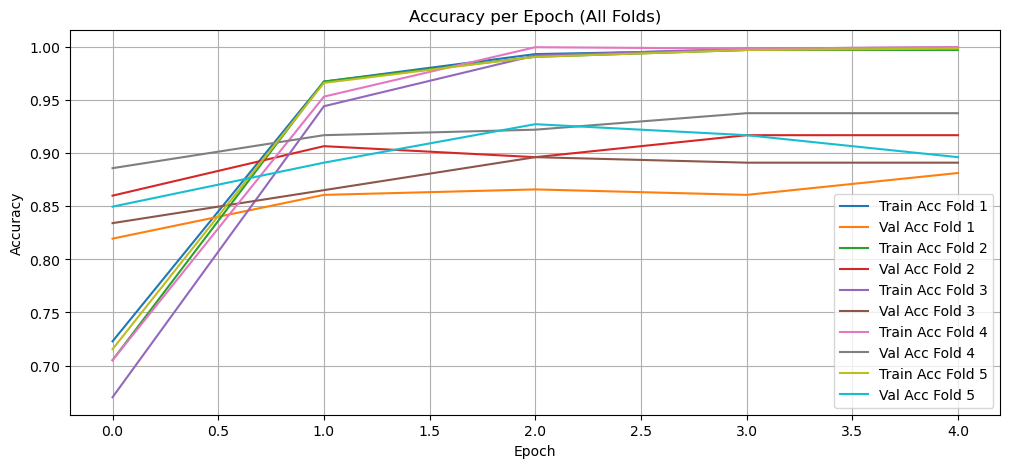

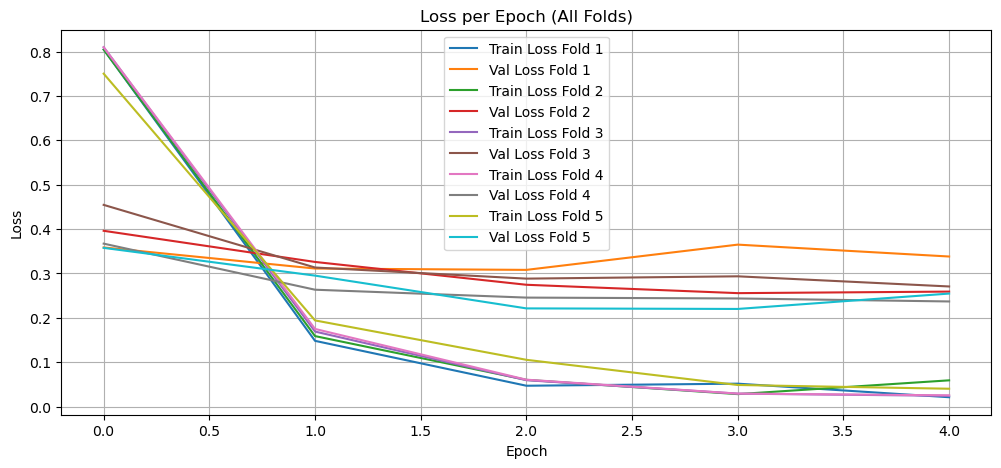

In [10]:
plt.figure(figsize=(12, 5))
for i, log in enumerate(fold_logs):
    plt.plot(log['train_acc'], label=f'Train Acc Fold {i+1}')
    plt.plot(log['val_acc'], label=f'Val Acc Fold {i+1}')
plt.title("Accuracy per Epoch (All Folds)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()  # Ensures the labels appear in the legend
plt.grid(True)
plt.show()

# Plot Loss per Epoch (All Folds)
plt.figure(figsize=(12, 5))
for i, log in enumerate(fold_logs):
    plt.plot(log['train_loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(log['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title("Loss per Epoch (All Folds)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()  # Ensures the labels appear in the legend
plt.grid(True)
plt.show()
